# Slot **Tagging**

### Load dataset, libraries and pre-trained embeddings

In [282]:
!git clone https://github.com/pranjali97/Slot-tagging-for-Natural-language-utterance.git

In [283]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

In [284]:
!unzip wiki-news-300d-1M.vec.zip

In [285]:
!pip install torch
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [286]:
import torch
from torch import nn

from torchtext import data

import pandas as pd
import numpy as np
import random
import os

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
nltk.download('omw-1.4')
nltk.download('wordnet')

from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

import contractions
from collections import Counter
import pickle
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [287]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [288]:
train = pd.read_csv('Slot-tagging-for-Natural-language-utterance/hw2_train.csv')
print('Training Samples: ',train.shape[0])

Training Samples:  2312


In [289]:
train["processed_utterances"]=train['UTTERANCES'].apply(lambda x: contractions.fix(x))
train['utterance_length'] = train['UTTERANCES'].apply(lambda x: len(x.split(' ')))
train['processed_utterance_length'] = train['processed_utterances'].apply(lambda x: len(x.split(' ')))
train['slot_length'] = train['IOB SLOT TAGS'].apply(lambda x: len(x.split(' ')))
train['processed_IOB'] = train['IOB SLOT TAGS'].apply(lambda x: x.split(' '))

In [290]:
# remove cases where token length didnt match with IOB slots after fixing contractions
train= train.query("processed_utterance_length == slot_length")
train.shape

(2247, 8)

In [291]:
train.head(5)

,ID,UTTERANCES,IOB SLOT TAGS,processed_utterances,utterance_length,processed_utterance_length,slot_length,processed_IOB
0,0,who plays luke on star wars new hope,O O B_char O B_movie I_movie I_movie I_movie,who plays luke on star wars new hope,8,8,8,"[O, O, B_char, O, B_movie, I_movie, I_movie, I..."
1,1,show credits for the godfather,O O O B_movie I_movie,show credits for the godfather,5,5,5,"[O, O, O, B_movie, I_movie]"
2,2,who was the main actor in the exorcist,O O O O O O B_movie I_movie,who was the main actor in the exorcist,8,8,8,"[O, O, O, O, O, O, B_movie, I_movie]"
3,3,find the female actress from the movie she's t...,O O O O O O O B_movie I_movie I_movie I_movie,find the female actress from the movie she is ...,10,11,11,"[O, O, O, O, O, O, O, B_movie, I_movie, I_movi..."
4,4,who played dory on finding nemo,O O B_char O B_movie I_movie,who played dory on finding nemo,6,6,6,"[O, O, B_char, O, B_movie, I_movie]"


In [292]:
train = train[['processed_utterances', 'processed_IOB']]
train = train.rename(columns={"processed_utterances": "text", "processed_IOB": "label"})

In [293]:
train.head()

,text,label
0,who plays luke on star wars new hope,"[O, O, B_char, O, B_movie, I_movie, I_movie, I..."
1,show credits for the godfather,"[O, O, O, B_movie, I_movie]"
2,who was the main actor in the exorcist,"[O, O, O, O, O, O, B_movie, I_movie]"
3,find the female actress from the movie she is ...,"[O, O, O, O, O, O, O, B_movie, I_movie, I_movi..."
4,who played dory on finding nemo,"[O, O, B_char, O, B_movie, I_movie]"


In [294]:
texts = train['text']
labels = train['label']

## Process Utterances

In [295]:
from collections import defaultdict

def tokenize(texts):

    max_len = 0
    tokenized_texts = []
    word2idx = {}
    lengths = []

    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    idx = 2
    for sent in texts:
        tokenized_sent = sent.split(' ')
        # lengths.append(len(tokenized_sent))
        tokenized_texts.append(tokenized_sent)
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

        max_len = max(max_len, len(tokenized_sent))

    return tokenized_texts, word2idx, max_len

In [296]:
tokenized_texts, word2idx, max_len = tokenize(texts)
vocab_size = len(word2idx)

In [297]:
def encode(tokenized_texts, word2idx, max_len):
    input_ids = []
    for tokenized_sent in tokenized_texts:
        # Pad sentences to max_len
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Encode tokens to input_ids
        input_id = [word2idx.get(token) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)  

In [298]:
input_ids = encode(tokenized_texts, word2idx, max_len)

In [299]:
print(len(input_ids))

2247


## Process Labels

In [300]:
all_labels = []
for label in labels:
    all_labels.extend(label)
unique_labels = set(all_labels)

In [301]:
len(unique_labels)

27

In [302]:
label_map = {'<PAD>': 0}
for (i, label) in enumerate(unique_labels):
    label_map[label] = i+1

print(label_map)

{'<PAD>': 0, 'B_genre': 1, 'I_director': 2, 'B_cast': 3, 'I_subject': 4, 'I_char': 5, 'I_release_year': 6, 'I_country': 7, 'I_mpaa_rating': 8, 'I_person': 9, 'O': 10, 'B_movie': 11, 'B_director': 12, 'B_producer': 13, 'I_language': 14, 'B_person': 15, 'B_release_year': 16, 'I-movie': 17, 'I_cast': 18, 'B_country': 19, 'B_mpaa_rating': 20, 'I_movie': 21, 'B_subject': 22, 'B_location': 23, 'B_language': 24, 'B_char': 25, 'I_producer': 26, 'I_genre': 27}


In [303]:
def pad_labels(labels, max_len):
  null_label = '<PAD>'
  padded_labels = []
  for label in labels:
    label.extend([null_label]*(max_len-len(label)))
    padded_labels.append(label)
  return padded_labels


In [304]:
padded_labels = pad_labels(labels, max_len)
processed_labels = []
for label in padded_labels:
  processed_labels.append([label_map[label_token] for label_token in label])

## Initialize pretrained word embeddings

In [305]:
def load_pretrained_vectors(word2idx, fname):
    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in fin:
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)

    print(f"{count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [306]:
# Load pretrained vectors
embeddings = load_pretrained_vectors(word2idx, "/content/wiki-news-300d-1M.vec")
embeddings = torch.tensor(embeddings, dtype = torch.float32)

Loading pretrained vectors...
1054 / 1146 pretrained vectors found.


In [307]:
# embeddings shape
embeddings.shape

torch.Size([1146, 300])

## Split data into train and validation

In [308]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, processed_labels, test_size=0.1, random_state=42)

In [309]:
print(len(train_inputs), len(val_inputs), len(train_labels), len(val_labels))

2022 225 2022 225


## Create dataset class

In [310]:
class dataset_class(Dataset):
    def __init__(self, x_data, y_data):
        self.xdata = x_data
        self.ydata = y_data
    
    def encode_text(self, text):
        return torch.tensor(text, device=device)

    def encode_label(self, label):
        return torch.tensor(label, device=device)
  
    def __getitem__(self, n: int):
        # print(n)
        text = self.xdata[n]
        label = self.ydata[n]
        return self.encode_text(text), self.encode_label(label)

    def __len__(self):
        return len(self.xdata)

In [311]:
train_df = dataset_class(train_inputs,train_labels)
val_df = dataset_class(val_inputs,val_labels)

### Set up dataloader for batch processing

In [312]:
batch_size = 64
train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_df, batch_size=batch_size, shuffle=True)

## Build Model

In [313]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
class BiLSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, output_dim, embeddings):
        super(BiLSTMTagger, self).__init__()
        self.embeddings = nn.Embedding.from_pretrained(embeddings)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=1, batch_first = True)
        # self.dropout_layer = nn.Dropout(p=0.5)
        self.hidden2op = nn.Linear(2*hidden_dim, output_dim)
        
    def forward(self, text):
      embeddings = self.embeddings(text)
      lstm_output, _ = self.lstm(embeddings)
      # lstm_output = self.dropout_layer(lstm_output)
      logits = self.hidden2op(lstm_output)
      logits = logits.view(-1, logits.shape[-1])
      return logits

In [314]:
embedding_dim = 300
vocab = 1146
hidden_dim = 256
unique_classes = len(label_map)
model = BiLSTMTagger(embedding_dim, hidden_dim, unique_classes, embeddings=embeddings)  

In [315]:
def train(loader, model, optimizer, loss_fn):
    model.train()
    losses = []
    pbar = tqdm(loader)
    for x, y in pbar:
        optimizer.zero_grad()
        logits = model(x)
        y = y.view(-1)
        batch_loss = loss_fn(logits, y)
        losses.append(batch_loss.item())
        batch_loss.backward() 
        optimizer.step() 
    return sum(losses)/len(losses)

def scoring_fn(labels, predictions):
    predicted_labels_without_mask = []
    correct_labels_without_mask = []
    for prediction, label in zip(predictions, labels):
      for p, c in zip(prediction, label):
        if c > 0:
          predicted_labels_without_mask.append(p)
          correct_labels_without_mask.append(c)
    acc_score = accuracy_score(predicted_labels_without_mask, correct_labels_without_mask)
    f1 = f1_score(predicted_labels_without_mask, correct_labels_without_mask, average = 'weighted')
    return acc_score, f1

def evaluate(loader, model, loss_fn):
    print('Starting validation')
    model.eval()
    predictions = []
    labels = []
    val_losses =[]
    for x, y in tqdm(loader):
        logits = model(x)
        y = y.view(-1)
        batch_loss = loss_fn(logits, y)
        pred = torch.tensor(logits)
        _, pred_indices = torch.max(pred, 1)
        predicted_label = list(pred_indices.cpu().numpy())
        val_losses.append(batch_loss.item())
        predictions.append(predicted_label)
        labels.append(y.tolist())
    acc_score, f1 = scoring_fn(labels, predictions)
    return sum(val_losses)/len(val_losses), acc_score, f1

In [316]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
n_epochs = 9
best_f1 = 0
epoch_training_loss = []
epoch_validation_loss = []
validation_accuracy = []
validation_f1 = []

for epoch in range(n_epochs):
    print('Epoch: ', epoch)
    train_loss = train(train_loader, model, optimizer, loss_fn)
    epoch_training_loss.append(train_loss)
    print('Train loss: ', epoch_training_loss)
    val_loss, accuracy, f1 = evaluate(val_loader, model, loss_fn)
    epoch_validation_loss.append(val_loss)
    validation_accuracy.append(accuracy)
    validation_f1.append(f1)
    print('Val Loss: ', epoch_validation_loss)
    print('Val accuracy: ', accuracy)
    print('Val f1', f1)
    if f1 > best_f1:
        best_f1 = f1

print('Best F1: ', best_f1)

Epoch:  0


100%|██████████| 32/32 [00:09<00:00,  3.46it/s]


Train loss:  [1.7189413718879223]
Starting validation


100%|██████████| 4/4 [00:00<00:00,  7.48it/s]


Val Loss:  [1.0287798345088959]
Val accuracy:  0.7338483146067416
Val f1 0.8417810549949539
Epoch:  1


100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


Train loss:  [1.7189413718879223, 0.9469235651195049]
Starting validation


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


Val Loss:  [1.0287798345088959, 0.8043370246887207]
Val accuracy:  0.7675561797752809
Val f1 0.845482916090085
Epoch:  2


100%|██████████| 32/32 [00:12<00:00,  2.61it/s]


Train loss:  [1.7189413718879223, 0.9469235651195049, 0.6895971372723579]
Starting validation


100%|██████████| 4/4 [00:00<00:00, 12.90it/s]


Val Loss:  [1.0287798345088959, 0.8043370246887207, 0.5241616144776344]
Val accuracy:  0.8335674157303371
Val f1 0.8710625001540948
Epoch:  3


100%|██████████| 32/32 [00:06<00:00,  4.71it/s]


Train loss:  [1.7189413718879223, 0.9469235651195049, 0.6895971372723579, 0.4615902425721288]
Starting validation


100%|██████████| 4/4 [00:00<00:00, 13.66it/s]


Val Loss:  [1.0287798345088959, 0.8043370246887207, 0.5241616144776344, 0.37048500776290894]
Val accuracy:  0.8960674157303371
Val f1 0.9056212010130118
Epoch:  4


100%|██████████| 32/32 [00:06<00:00,  4.72it/s]


Train loss:  [1.7189413718879223, 0.9469235651195049, 0.6895971372723579, 0.4615902425721288, 0.32093217177316546]
Starting validation


100%|██████████| 4/4 [00:00<00:00, 12.86it/s]


Val Loss:  [1.0287798345088959, 0.8043370246887207, 0.5241616144776344, 0.37048500776290894, 0.278659213334322]
Val accuracy:  0.9220505617977528
Val f1 0.9268097514342135
Epoch:  5


100%|██████████| 32/32 [00:06<00:00,  4.65it/s]


Train loss:  [1.7189413718879223, 0.9469235651195049, 0.6895971372723579, 0.4615902425721288, 0.32093217177316546, 0.24310213001444936]
Starting validation


100%|██████████| 4/4 [00:00<00:00, 13.65it/s]


Val Loss:  [1.0287798345088959, 0.8043370246887207, 0.5241616144776344, 0.37048500776290894, 0.278659213334322, 0.21841861307621002]
Val accuracy:  0.9382022471910112
Val f1 0.9403453211654796
Epoch:  6


100%|██████████| 32/32 [00:06<00:00,  4.77it/s]


Train loss:  [1.7189413718879223, 0.9469235651195049, 0.6895971372723579, 0.4615902425721288, 0.32093217177316546, 0.24310213001444936, 0.19856295362114906]
Starting validation


100%|██████████| 4/4 [00:00<00:00, 13.45it/s]


Val Loss:  [1.0287798345088959, 0.8043370246887207, 0.5241616144776344, 0.37048500776290894, 0.278659213334322, 0.21841861307621002, 0.18961532413959503]
Val accuracy:  0.9466292134831461
Val f1 0.9475908213103971
Epoch:  7


100%|██████████| 32/32 [00:06<00:00,  4.78it/s]


Train loss:  [1.7189413718879223, 0.9469235651195049, 0.6895971372723579, 0.4615902425721288, 0.32093217177316546, 0.24310213001444936, 0.19856295362114906, 0.15916925156489015]
Starting validation


100%|██████████| 4/4 [00:00<00:00, 12.18it/s]


Val Loss:  [1.0287798345088959, 0.8043370246887207, 0.5241616144776344, 0.37048500776290894, 0.278659213334322, 0.21841861307621002, 0.18961532413959503, 0.15192684903740883]
Val accuracy:  0.9564606741573034
Val f1 0.9565311754118853
Epoch:  8


100%|██████████| 32/32 [00:06<00:00,  4.71it/s]


Train loss:  [1.7189413718879223, 0.9469235651195049, 0.6895971372723579, 0.4615902425721288, 0.32093217177316546, 0.24310213001444936, 0.19856295362114906, 0.15916925156489015, 0.1384061025455594]
Starting validation


100%|██████████| 4/4 [00:00<00:00, 13.26it/s]

Val Loss:  [1.0287798345088959, 0.8043370246887207, 0.5241616144776344, 0.37048500776290894, 0.278659213334322, 0.21841861307621002, 0.18961532413959503, 0.15192684903740883, 0.1435908656567335]
Val accuracy:  0.9585674157303371
Val f1 0.9598930842186316
Best F1:  0.9598930842186316


In [317]:
best_f1

0.9598930842186316

## Visualize Training loss, validation loss and validation F1

<Figure size 432x288 with 0 Axes>

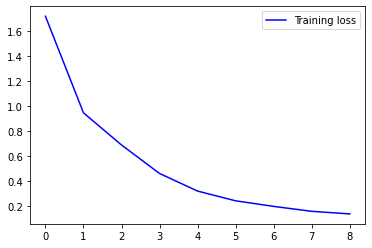

<Figure size 432x288 with 0 Axes>

In [318]:
epoch_range = range(epoch+1)

plt.plot(epoch_range, epoch_training_loss, 'b', label='Training loss')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

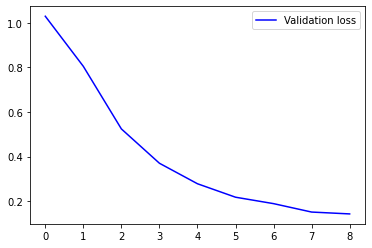

<Figure size 432x288 with 0 Axes>

In [319]:
epoch_range = range(epoch+1)

plt.plot(epoch_range, epoch_validation_loss, 'b', label='Validation loss')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

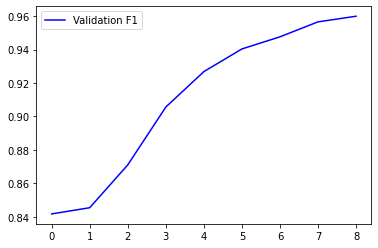

<Figure size 432x288 with 0 Axes>

In [320]:
plt.plot(epoch_range, validation_f1, 'b', label='Validation F1')
plt.legend()
plt.figure()

## Run Inference

In [321]:
# Generate test data

test = pd.read_csv('Slot-tagging-for-Natural-language-utterance/hw2_test.csv')
print('Test Samples: ',test.shape[0])

test.head()


Test Samples:  981


,ID,UTTERANCES
0,0,star of thor
1,1,who is in the movie the campaign
2,2,list the cast of the movie the campaign
3,3,who was in twilight
4,4,who is in vulguria


In [322]:
test['tokenized_text'] = test['UTTERANCES'].apply(lambda x: x.split(' '))
test_texts = test['tokenized_text'].tolist()
test_texts
test_text_lengths = []
test_input_ids = []
for sent in test_texts:
  test_text_lengths.append(len(sent))
  for token in sent:
    if word2idx.get(token):
      test_input_ids.append(word2idx.get(token))
    else:
      test_input_ids.append(1)

len(test_text_lengths)

981

In [323]:
x_test = torch.tensor(test_input_ids)
with torch.no_grad():
    model.eval()
    log_ps = model(x_test)
    pred = torch.tensor(log_ps)
    _, pred_indices = torch.max(pred, 1)

predicted_label = list(pred_indices.cpu().numpy())
idx = 0
processed_pred = []
for length in test_text_lengths:
  processed_pred.append(predicted_label[idx:idx+length])
  idx += length

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [324]:
# decode labels to original tokens
decoded_predictions = []
for pred_sent in processed_pred:
  decoded_pred = []
  for pred in pred_sent:
    decoded_pred.extend([k for k, v in label_map.items() if v == pred])
  decoded_predictions.append(decoded_pred)
  
len(decoded_predictions)

981

In [325]:
# confirm sequence lengths and label lengths match
test['iob'] = decoded_predictions
test['IOB Slot tags'] = test['iob'].apply(lambda x: ' '.join(x))
test['IOB_length'] = test['IOB Slot tags'].apply(lambda x: len(x.split(' ')))
test['utterance_length'] = test['UTTERANCES'].apply(lambda x: len(x.split(' ')))
test['IOB_length'].equals(test['utterance_length'])

True

In [329]:
test = test[['ID', 'IOB Slot tags']]

In [328]:
test.to_csv('submission.csv',index=False)